# Generative AI for image esthetics evaluation

GitHub page: https://github.com/MicheleUIT/gen-ai-photography

Authors:
- Michele Guerra
- Remi Kristoffer Aronsen
- Sebastian Tendstrand Iversen

# 1. Introduction

(Introduction written with the help of ChatGPT)

Photography is an art form deeply rooted in personal expression and creativity, allowing photographers to capture and convey their unique perspectives. Despite its subjective nature, there are established guidelines and best practices that can enhance the visual appeal of images. One of the most fundamental principles is the rule of thirds, which involves dividing an image into a 3x3 grid and aligning the main elements along these lines or their intersections. This technique helps create balanced, engaging, and aesthetically pleasing photographs.

In the age of digital media, assessing the esthetics of an image computationally has become increasingly valuable. For instance, search engines can utilize these assessments to prioritize and display the most visually appealing images, enhancing user experience and engagement. Moreover, platforms that host large volumes of visual content, such as social media sites and online galleries, can benefit from algorithms that curate and highlight high-quality images.

However, developing algorithms that can accurately evaluate and improve the esthetics of photographs poses significant challenges. The subjective nature of art means that what one person finds beautiful, another might not. Additionally, computational models must account for a vast array of styles, contexts, and personal preferences, which adds complexity to the task.

Our project envisions a solution in the form of a mobile application that leverages generative AI tools for both images and text. This app would assist users in enhancing their photographs by suggesting improvements based on established aesthetic principles and personal preferences. By providing real-time feedback and recommendations, the app aims to help users create more visually compelling images, thereby bridging the gap between computational analysis and artistic expression.

This report is structured as follows:
1. First we try to come up with a way to measure quantitatively the esthetics of an image.
2. Then we present a workflow which, by using object detection, segmentation masks and content-aware infilling, adjust an image according to the rule of thirds.
3. We evaluate how good is a pre-trained chatbot in providing suggestions on how to improve an input image.

# 2. Esthetic evaluation


In order to check whether our methods improve in some sense the quality of the input image, we would need a reliable way to measure the esthetic quality of the picture.

Evaluating quantitatively and computationally the esthetics of a picture is challenging for multiple reasons [1]:
1. complicated photographic rules or abstract art principles
2. variety of image subjects (people, animals, architecture, ...) or genres (portrait, street photography, landscape, ...)
3. knowledge of technical details and camera settings (lighting, sharpness, depth-of-field, motion blur, ...)
4. having sufficiently large datasets of aesthetic evaluation.

## 2.1 Background

Historically, the first attempts at using machine learning for image-quality assessment were done via simple supervised classifiers like SVM, while later it has been tried to employ CNNs with better success [4] (find an example in [this Nvidia blog post](https://developer.nvidia.com/blog/understanding-aesthetics-deep-learning/)). Most recent attempts veered towards self-supervised methods like contrastive learning [5].


## 2.2 Dataset

As dataset we chose to use the [AADB dataset](https://ics.uci.edu/~skong2/aesthetics.html) [2] which is formed of 10000 images with an overall esthetic score and binary labels for 8 attributes - balancing element, colour harmony, interesting content, shallow depth of field, good lightning, object emphasis, rule of thirds, vivid colour - rated manually by 5 experts.

For example, the following image has an overall esthetic score of 0.7

<img src="report_images\farm1_260_20135299762_a988319739_b.jpg" alt="Example image from AADB dataset" width="500"/>

Unfortunately, the dataset doesn't fit on GitHub and we could only get it from the authors upon request. Some cells (clearly marked) of this notebook require the dataset to run, if you wish to re-run those parts by yourself contact us and we will share the dataset via other means.

Since in our analysis we will also need a caption for each image, which the original dataset doesn't have, we used an image-to-text model ([Llama](https://huggingface.co/meta-llama/Meta-Llama-3-8B)) to produce a description of the content of each image.
In the example above that is "Two boys walking through a grassy field, one in front of the other."

All produced captions are contained in dataset\data\aadb_prompts.txt

Notice that we only produced a caption for 1/3 of the dataset, because processing it completely was taking too much time.

## 2.3 Our approach

As a first step, let's first check if current image-generating models have learned, in their training, some sort of concept of esthetics.

To do so, we use a [pre-trained image-to-image model from HuggingFace](https://huggingface.co/runwayml/stable-diffusion-v1-5)

In [2]:
import torch
from diffusers import StableDiffusionImg2ImgPipeline

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pre-trained model
model_id_or_path = "runwayml/stable-diffusion-v1-5"
pipe = StableDiffusionImg2ImgPipeline.from_pretrained(model_id_or_path, torch_dtype=torch.float16)
pipe = pipe.to(device)

c:\Users\mgphy\Anaconda3\envs\genai-test\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\mgphy\Anaconda3\envs\genai-test\lib\site-packages\diffusers\models\transformers\transformer_2d.py:34: FutureWarning: `Transformer2DModelOutput` is deprecated and will be removed in version 1.0.0. Importing `Transformer2DModelOutput` from `diffusers.models.transformer_2d` is deprecated and this will be removed in a future version. Please use `from diffusers.models.modeling_outputs import Transformer2DModelOutput`, instead.
  deprecate("Transformer2DModelOutput", "1.0.0", deprecation_message)
Loading pipeline components...: 100%|██████████| 7/7 [00:01<00:00,  3.95it/s]


In [4]:
import requests
from PIL import Image
from io import BytesIO

url = "https://raw.githubusercontent.com/CompVis/stable-diffusion/main/assets/stable-samples/img2img/sketch-mountains-input.jpg"

response = requests.get(url)
init_image = Image.open(BytesIO(response.content)).convert("RGB")
init_image = init_image.resize((768, 512))

prompt1 = "A fantasy landscape, ugly hand sketch"
prompt2 = "A fantasy landscape, Caravaggio painting"

image0 = pipe(prompt=prompt1, image=init_image, strength=0.75, guidance_scale=7.5).images[0]
image1 = pipe(prompt=prompt2, image=init_image, strength=0.75, guidance_scale=7.5).images[0]

c:\Users\mgphy\Anaconda3\envs\genai-test\lib\site-packages\diffusers\models\attention_processor.py:1416: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  hidden_states = F.scaled_dot_product_attention(
100%|██████████| 37/37 [00:07<00:00,  4.83it/s]


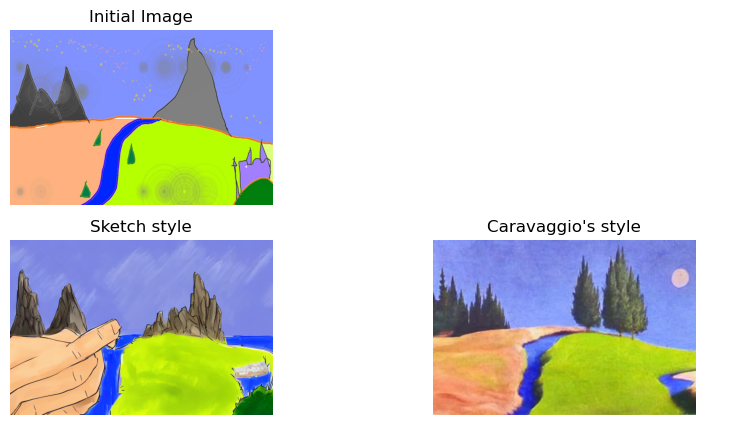

In [6]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 2, figsize=(10, 5))

axs[0,0].imshow(init_image)
axs[0,0].set_title("Initial Image")
axs[0,0].axis('off')
axs[0,1].axis('off')

axs[1,0].imshow(image0)
axs[1,0].set_title("Sketch style")
axs[1,0].axis('off')

axs[1,1].imshow(image1)
axs[1,1].set_title("Caravaggio's style")
axs[1,1].axis('off')

plt.show()

We can see that the model has learned during its training different types of style, so we want to test if the model is able to distinguish between "good" and "bad" looking images and if we can leverage that distinction to define an esthetic metric.

Let's first see more in details what's the structure of the stable diffusion model employed above. Essentially, it consists of three components:
1. an autoencoder (VAE)
2. a U-Net
3. a text encoder (CLIP).

<img src="report_images\stable-diffusion.png" alt="Scheme of the structure of stable diffusion" width="500"/>

If the model has learned a distinction between "good" and "bad" images, that difference should be encoded somehow within the embedding space of VAE's encoder $z$ or in U-Net's embeddings $\hat{z}$.

In the example above, those two embeddings are the following:

c:\Users\mgphy\Anaconda3\envs\genai-test\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: 'Could not find module 'C:\Users\mgphy\anaconda3\envs\genai-test\Lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


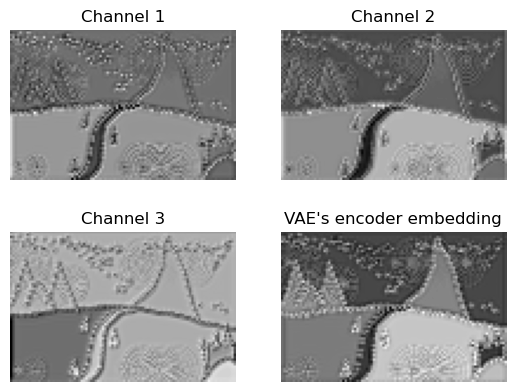

In [7]:
import torchvision.transforms as transforms
from diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_img2img import retrieve_latents

transform = transforms.ToTensor()
tensor_image = transform(init_image).to(device=device, dtype=torch.half).unsqueeze(0)

z = retrieve_latents(pipe.vae.encode(tensor_image))

# Assuming latents is a tensor with shape (batch, latent_channels, width, height)
fig, axs = plt.subplots(2, 2)

# Plotting the four channels separately
for i, ax in enumerate(axs.flat):
    ax.imshow(z[0, i].cpu().detach().numpy(), cmap='gray')
    ax.axis('off')
    ax.set_title(f'Channel {i+1}')

plt.title("VAE's encoder embedding")
plt.show()

100%|██████████| 37/37 [00:07<00:00,  4.79it/s]


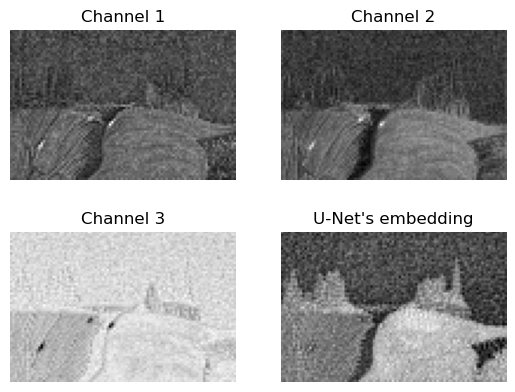

In [8]:
# Change the output type to get U-Net's latent
z_hat = pipe(prompt=prompt2, image=init_image, strength=0.75, guidance_scale=7.5, output_type='latent').images

# Assuming latents is a tensor with shape (batch, latent_channels, width, height)
fig, axs = plt.subplots(2, 2)

# Plotting the four channels separately
for i, ax in enumerate(axs.flat):
    ax.imshow(z_hat[0, i].cpu().detach().numpy(), cmap='gray')
    ax.axis('off')
    ax.set_title(f'Channel {i+1}')

plt.title("U-Net's embedding")
plt.show()

In order to produce U-Net's embedding, captions of the images were required. That's why we run Llama image-to-text model on a portion of the dataset to produce a description of each image. You can find it in `dataset/data/aadb_prompts.txt` which was produced by launching the script `dataset/promptify_images.py`.

U-Net's embeddings for a portion of the dataset were then retrieved using the script `dataset/unet_embeddings.py`. We only did it for a third of the dataset because it was taking too long.

The naif approach to test our hypothesis can be described as follows:
1. We can perform PCA analysis on $z$ and $\hat{z}$ and ideally find a principal component that corresponds to some esthetic quality.
2. If the above fails, we can train a simple binary classifier on embeddings and check if it is able to learn a difference between "good" and "bad" images.

The approach is naif and we don't really expect it to work, since it relies on whether the stable diffusion model learned that difference at all, and also, that difference (if it exists) may well be overshadowed by other noisy factors stemming from the variety of images contained in the dataset. It would have been useful to have a dataset consisting of just one subject, but we couldn't find it. Anyway, despite the naivety, it's worth a try.

### 2.3.1 VAE's encoder embeddings analysis

__Warning__: to run this cell you need the dataset, which is too big to fit into the GitHub repository. Get in touch to the authors to receive the dataset.

You only need to run this cell the first time, results are saved to npy files.

In [ ]:
import numpy as np
from diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_img2img import retrieve_latents
from tqdm import tqdm
from dataset.utils import AADBDataset

dataset = AADBDataset('dataset/data/datasetImages_originalSize', 'dataset/data')

latents = []
scores = []

for i in tqdm(range(len(dataset))):
    image, score = dataset[i]['image'], dataset[i]['score']
    image = image.to(device=device, dtype=torch.half).unsqueeze(0)
    latent = retrieve_latents(pipe.vae.encode(image))
    latents.append(latent.detach().cpu().numpy())
    scores.append(score)

latents = np.array(latents).squeeze()
scores = np.array(scores)

np.save('dataset/data/saved/vae_latents.npy', latents)
np.save('dataset/data/saved/scores.npy', scores)

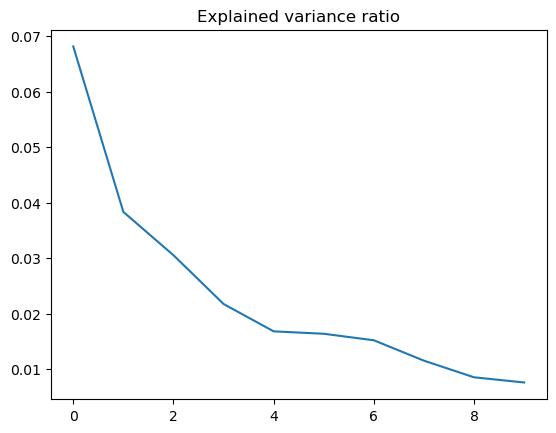

In [11]:
import numpy as np
from sklearn.decomposition import PCA
from einops import rearrange
import matplotlib.pyplot as plt

# Load VAE's encoder embeddings and the overall esthetic score

latents = np.load('dataset/data/saved/vae_latents.npy')
scores = np.load('dataset/data/saved/scores.npy')

# Split the dataset into train and test
train_size = int(len(latents) * 0.8)
embeds = rearrange(latents, 'b c w h -> b (c w h)')
train_embeds = embeds[:train_size, :]
test_embeds = embeds[train_size:, :]

# Fit PCA on the training set
pca = PCA(n_components=10)
pca.fit(train_embeds)

# Transform the embeddings
embeds_pca = pca.transform(test_embeds)
test_scores = scores[train_size:]

# Plot the explained variance ratio
plt.title("Explained variance ratio")
plt.plot(pca.explained_variance_ratio_)
plt.show()

As you can see from the plot, each principal component is able to capture quite a small portion of the variance, a symptom of the fact that the encoder's embedding space doesn't manage to disentangle well enough all different sources of variance, as expected.

We can also try to exacerbate the distinction between bad and pretty images by considering only images with scores lower than 0.2 and higher than 0.8.

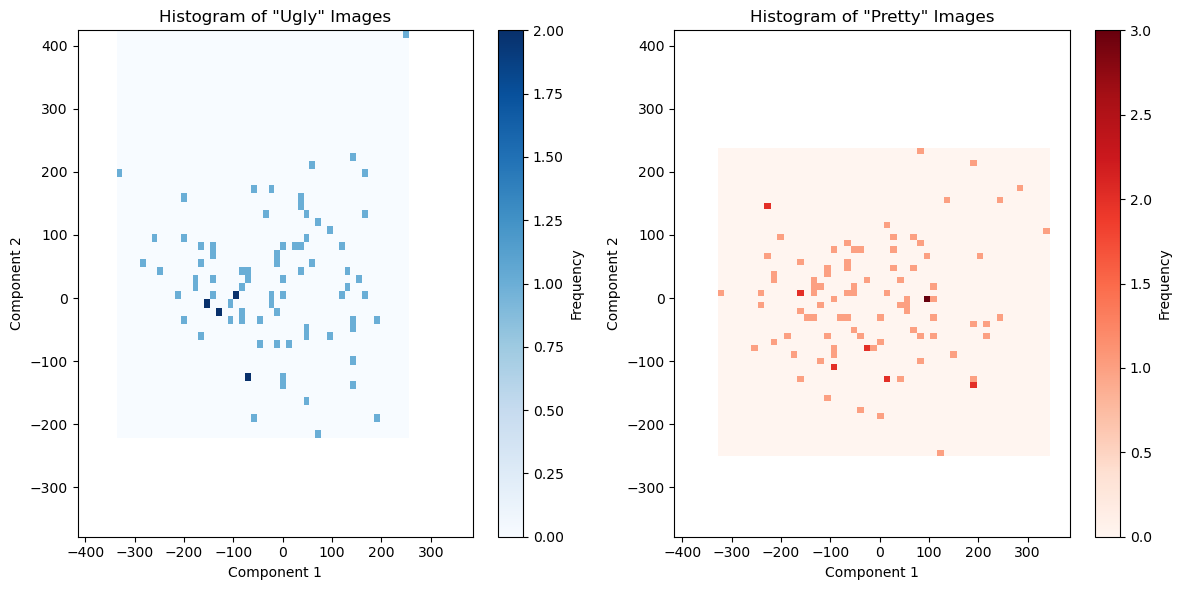

In [12]:
ugly_idx = test_scores < 0.2
pretty_idx = test_scores > 0.8

ugly_img = embeds_pca[ugly_idx]
pretty_img = embeds_pca[pretty_idx]

plt.figure(figsize=(12, 6))

# Plotting the histogram for "ugly" images
plt.subplot(1, 2, 1)
plt.hist2d(ugly_img[:, 0], ugly_img[:, 1], bins=50, cmap='Blues')
plt.colorbar(label='Frequency')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('Histogram of "Ugly" Images')
plt.xlim(np.min(embeds_pca[:, 0]), np.max(embeds_pca[:, 0]))
plt.ylim(np.min(embeds_pca[:, 1]), np.max(embeds_pca[:, 1]))

# Plotting the histogram for "pretty" images
plt.subplot(1, 2, 2)
plt.hist2d(pretty_img[:, 0], pretty_img[:, 1], bins=50, cmap='Reds')
plt.colorbar(label='Frequency')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('Histogram of "Pretty" Images')
plt.xlim(np.min(embeds_pca[:, 0]), np.max(embeds_pca[:, 0]))
plt.ylim(np.min(embeds_pca[:, 1]), np.max(embeds_pca[:, 1]))

plt.tight_layout()
plt.show()

It doesn't seem like there is a clear distinction at this stage between ugly and pretty images.

Let's try with a classifier:

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

pretty_idx = scores > 0.5

# Split the data into train and test sets
embeds = rearrange(latents, 'b c w h -> b (c w h)')
X_train, X_test, y_train, y_test = train_test_split(embeds, pretty_idx, test_size=0.2, random_state=42)

# Create a logistic regression classifier
classifier = LogisticRegression(max_iter=1000)

# Train the classifier
classifier.fit(X_train, y_train)

# Predict on the test set
y_pred = classifier.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.5496987951807228


As expected, the accuracy is not great, meaning that indeed at this stage the model is not able to distinguish between pretty and ugly images.

### 2.3.2 U-Net's embeddings analysis

Let's try the same analysis on U-Net's embeddings instead.

__Warning__: To execute this cell you need the dataset, get in touch to the authors to receive it.
Before runnung this cell you should run the script `unet_embeddings.py`, which takes a _long_ time.

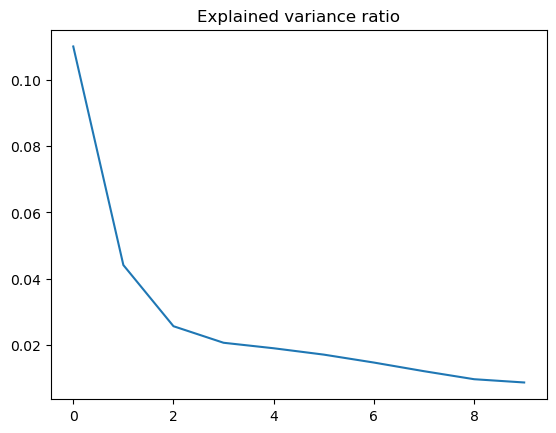

In [14]:
import numpy as np
from sklearn.decomposition import PCA
from einops import rearrange
import matplotlib.pyplot as plt

# Load U-Net's embeddings and the overall esthetic score
latents = np.load('dataset/data/saved/unet_latents.npy')
scores = np.load('dataset/data/saved/scores.npy')

# Check for NaN values in latents
nan_mask = np.isnan(latents)

# Replace NaN values with random numbers
n_latents = latents.copy()
n_latents[nan_mask] = np.random.rand(np.sum(nan_mask))

# Split the dataset into train and test
train_size = int(len(n_latents) * 0.8)
embeds = rearrange(n_latents, 'b c w h -> b (c w h)')
train_embeds = embeds[:train_size, :]
test_embeds = embeds[train_size:, :]

# Fit PCA on the training set
pca = PCA(n_components=10)
pca.fit(train_embeds)

# Transform the embeddings
embeds_pca = pca.transform(test_embeds)
scores = scores[:len(latents)]
test_scores = scores[train_size:]

# Plot the explained variance ratio
plt.title("Explained variance ratio")
plt.plot(pca.explained_variance_ratio_)
plt.show()

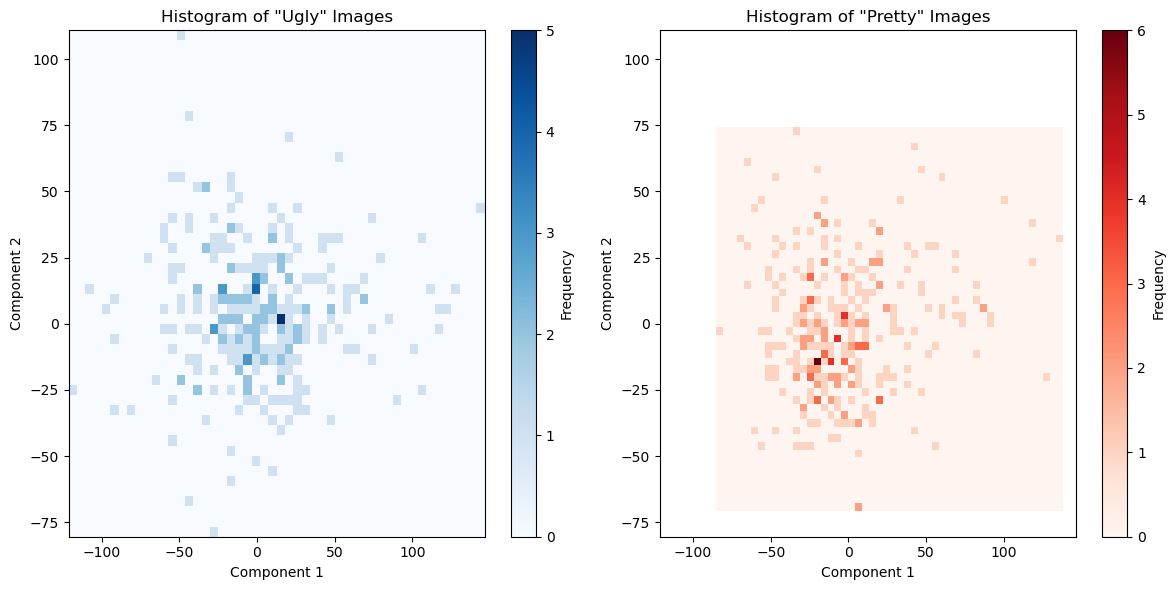

In [15]:
ugly_idx = test_scores < 0.5
pretty_idx = test_scores > 0.5

ugly_img = embeds_pca[ugly_idx]
pretty_img = embeds_pca[pretty_idx]

plt.figure(figsize=(12, 6))

# Plotting the histogram for "ugly" images
plt.subplot(1, 2, 1)
plt.hist2d(ugly_img[:, 0], ugly_img[:, 1], bins=50, cmap='Blues')
plt.colorbar(label='Frequency')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('Histogram of "Ugly" Images')
plt.xlim(np.min(embeds_pca[:, 0]), np.max(embeds_pca[:, 0]))
plt.ylim(np.min(embeds_pca[:, 1]), np.max(embeds_pca[:, 1]))

# Plotting the histogram for "pretty" images
plt.subplot(1, 2, 2)
plt.hist2d(pretty_img[:, 0], pretty_img[:, 1], bins=50, cmap='Reds')
plt.colorbar(label='Frequency')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('Histogram of "Pretty" Images')
plt.xlim(np.min(embeds_pca[:, 0]), np.max(embeds_pca[:, 0]))
plt.ylim(np.min(embeds_pca[:, 1]), np.max(embeds_pca[:, 1]))

plt.tight_layout()
plt.show()

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

pretty_idx = scores > 0.5

# Split the data into train and test sets
embeds = rearrange(n_latents, 'b c w h -> b (c w h)')
X_train, X_test, y_train, y_test = train_test_split(embeds, pretty_idx, test_size=0.2, random_state=42)

# Create a logistic regression classifier
classifier = LogisticRegression(max_iter=1000)

# Train the classifier
classifier.fit(X_train, y_train)

# Predict on the test set
y_pred = classifier.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.5301204819277109


It seems that also the Unet embeddings do not represent the difference between ugly and pretty images in an explicit way.

Another approach that we attempted, but we don't report here for brevity, was to modify the description of the images so as to accentuate the skewness of the U-Net's embeddings between ugly and pretty images. For example, by adding strings like "professional/amateur photography". But it didn't help either.

Probably the pre-trained model that we used is not expressive enough to grasp the difference in esthetic quality. A possible way to fix this, which goes beyond the scopes of this course, is to replace the pre-trained VAE with another one, trained specifically on the task, maybe based on $\beta$-VAE [3], so that ideally one gets an "esthetic direction" in the embedding space.

In conclusion, our attempt at finding a way to quantitatively measure the esthetic quality of an image failed, so in the rest of the project we will rely on our subjective opinion to assess if our take at using geneerative AI tools to improve pictures actually works.

# 3. Reframing pipeline


The reframing pipeline's objective is to identify the subject within an image and then modify the image accordingly. This modification involves shifting and zooming to align the subjects with the thirds. The term thirds refer to the point of the picture if you were to draw lines splitting the image in three in height and with a third is a point where those lines intersect. 
In the process of shifting and zooming, parts of the image that were previously outside the frame may become visible. To ensure a complete and visually appealing image, these newly visible areas are filled in using an image restoration technique known as inpainting. Inpainting effectively reconstructs the lost or deteriorated parts of the image, resulting in a well-framed and complete image. To use this pipeline run main.py but need first define path to image.

## 3.1 AI models used in the pipeline

object detection:
https://huggingface.co/facebook/detr-resnet-50

cloathing detection:
https://huggingface.co/mattmdjaga/segformer_b2_clothes

Inpaint:
https://huggingface.co/docs/diffusers/api/pipelines/stable_diffusion/inpaint

## 3.2 Flowchart of reframing pipeline
![Alt text](report_images/reframing_flowchart.png)

## 3.3 Explaination of pipeline

The pipeline begins with inputting an image. On this image we perform object detection. Here we identify each unique object and output this as text to the user so the user can pick its wanted subject. 
Then we extract the bounding boxes of the objects which matches the one to be the subject.  For a normal object we define the focus point of the subjects(s) to be the middle of the bounding box. If the object is “person” we crop out each person based on the bounding box and do a clothing detection on each sub image. This gives us a semantic segmentation map. We use the classes which corresponds to head such as head, hair and hat and calculate the average position of them to give us an estimate of center of head which we use as focus point. 

Then we feed it to a reframing algorithm which shifts zoom the image based on the focus points and the number of them to best fit the subject to the thirds. This is an self-made algorithm.
Here if we only have one subject, we just calculate the difference between the focal point and the nearest third and shifts the image that amount. 

If we have 2 or more objects the reframing is more complex. If we have more than 2 subjects we want to pick out 2 of them we can fit to and ignore the rest for simplicity. We do this by using the position of the points and draw a regression line and pick out the point which when projected to the lines is the two on the edges so that the other points are between them. Now we have 2 points to fit to the thirds. Here we want to fit them to two different thirds. We calculate a vector drawn between the lines in a normalized space where width and height are normalized to 1. Then we calculate the ratio of the height difference by the width difference. If it is more than 2 we fit them to a vertical pair of thirds, if between 2 and 0,5 we fit them on an diagonal and if less than 0,5 we fit them horizontally. Now each of these has only two options of points to fit to. For the diagonal case we can just see if it is an upwards or downwards slope. If it slopes downwards, we fit it to top left third and bottom right third and the opposite pair otherwise. For the horizontal and vertical cases, we just check which half of the image the average of the point is in. For example, in the horizontal case if the average height is above the half-line we fit it to the third in top left and top right.

now that we have chosen 2 thirds to fit to, we can shift the average position of our focal point such that it is in the middle of the two thirds we chose to fit to. Then we do a zooming operation where we keep the origin of the zoom at the point between the two chosen third. Then we zoom with a factor to get the two focal point nearer to the thirds.

During this whole operation we also have an mask which tracks which part of the new reframed image was previously outside it. This will look like blank or black spaces in the reframed images before we do the inpainting.

Now we have a reframed image and a mask we can feed it to the inpaint model to paint in the areas which was previously outside the image to fill in the background. Note the Inpaint model used takes in images of size 512x512 pixels therefore we resize the images to this before feeding to the model. Then afterwards we resize it to the original shape. Then to minimize the loss of quality we replace the areas which did not get filled in with the original images to not lose quality. One backside of this is the filled in areas might have lover quality, but this area is supposed to be a part of the background, so we care less about it then the main part of the image.

## 3.4 Some Example


### 3.4.1 Example person

In [17]:
from reframe import *
from infill import Infill
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [18]:

#set seed
seed = 500
set_seed(seed)#set seed for reproducibility


Using an example image I took of myself

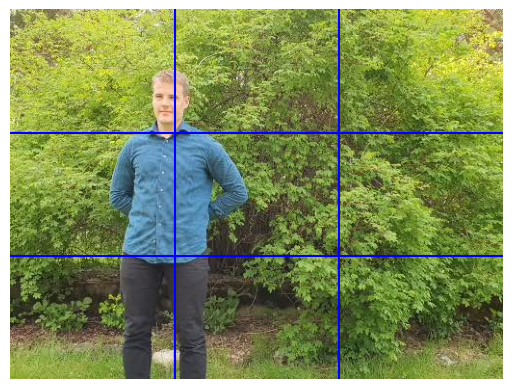

In [19]:
#Set the path to the image
Example_image_path ="report_images\Example_person.png"

Example_image = Image.open(Example_image_path)
width, height = Example_image.size

plt.imshow(Example_image)
plt.axis('off')
Draw_thirds(height, width)
plt.show()

In the example we see that the face does not perfectly line up with any of the thirds but is very close to the top left one.

First we will see what the object detection sees.

c:\Users\mgphy\Anaconda3\envs\genai-test\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
c:\Users\mgphy\Anaconda3\envs\genai-test\lib\site-packages\huggingface_hub\file_download.py:157: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\mgphy\.cache\huggingface\hub\models--facebook--detr-resnet-50. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Py

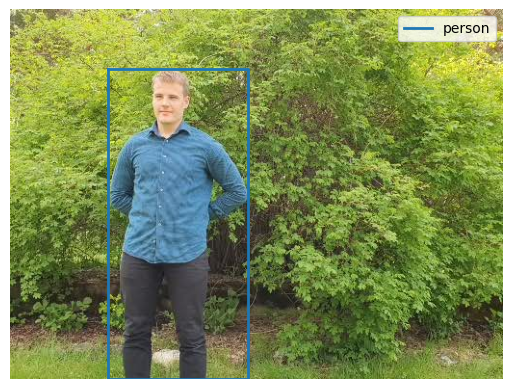

In [20]:
set_seed(seed)
Display_object_detection(Example_image)

Here we see that the object detection has correctly detected the person in the image. Since we are reframing for “person” the pipeline would take the person path as seen in the flowchart.

c:\Users\mgphy\Anaconda3\envs\genai-test\lib\site-packages\huggingface_hub\file_download.py:157: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\mgphy\.cache\huggingface\hub\models--mattmdjaga--segformer_b2_clothes. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
c:\Users\mgphy\Anaconda3\envs\genai-test\lib\site-packages\transformers\models\segformer\ima

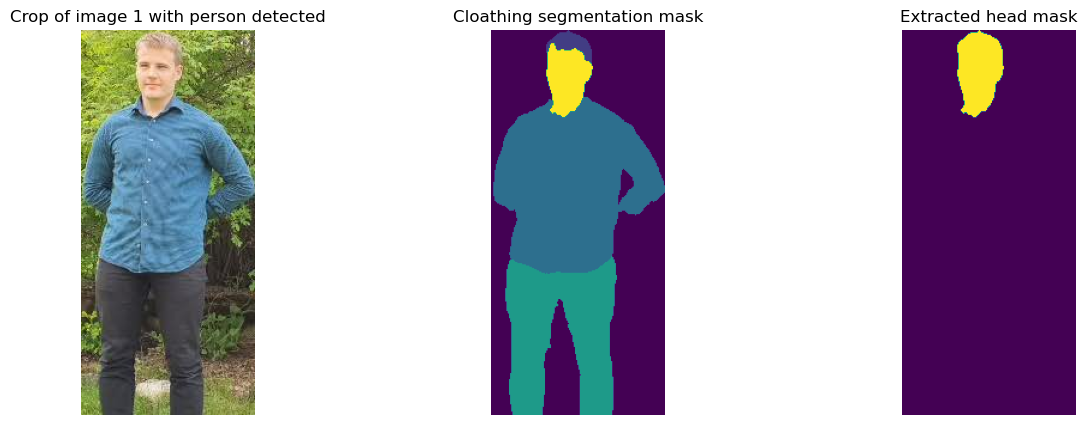

In [21]:
set_seed(seed)
person_images, boxes = crop_subjects(Example_image, "person",return_boxes = True)
person_image = person_images[0]
box = boxes[0]

fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # 1 row, 3 columns

# Assuming person_image1, person_image2, person_image3 are your images
axs[0].imshow(person_image)
axs[0].set_title("Crop of image 1 with person detected")
axs[0].axis('off')


head_pos,seg, mask =  get_person_cordinate(person_image, return_segmentation = True, return_head_segmentation = True)



axs[1].imshow(seg)
axs[1].set_title("Cloathing segmentation mask")
axs[1].axis('off')

axs[2].imshow(mask)
axs[2].set_title("Extracted head mask")
axs[2].axis('off')

plt.show()


From the head segmentation it calculates the average position of the head segmentation to get an estimated center of head.

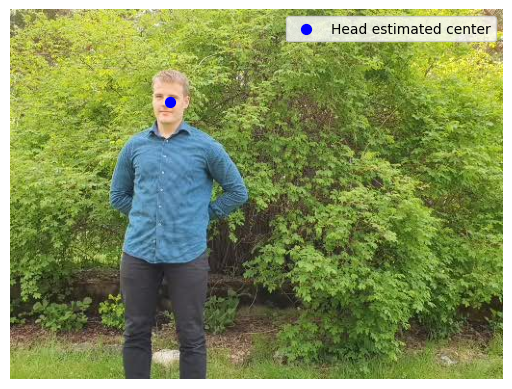

In [22]:
head_pos_Example_image = (head_pos[0] + box[1], head_pos[1] + box[0])

plt.imshow(Example_image)
plt.axis('off')
plt.scatter(head_pos_Example_image[1], head_pos_Example_image[0], c='b', s=50, label='Head estimated center')
plt.legend()
plt.show()

Now the algorithm can shift the image such that the center of the head matches the closest third.

In [23]:
set_seed(seed)
reframed_Example_image, Example_image_mask = refram_to_thirds(Example_image, Subject = "person", Return_mask = True)

Number of subjects: 1


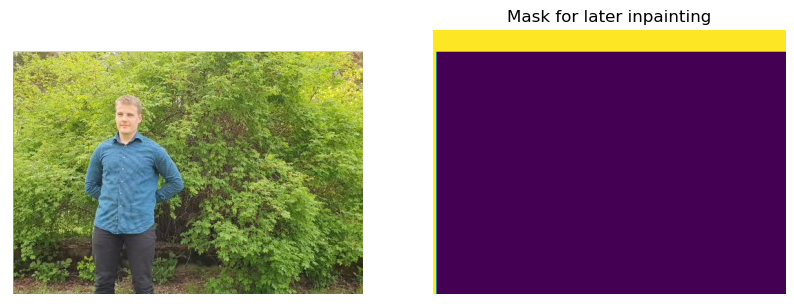

In [24]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))  # Create 2 subplots

# First subplot for the original image
axs[0].imshow(reframed_Example_image)
plt.title("Reframed image")
axs[0].axis('off')

# Second subplot for the mask
# Assuming 'mask' is the variable holding your mask data
axs[1].imshow(Example_image_mask)
plt.title("Mask for later inpainting")
axs[1].axis('off')

plt.show()


Here we see that the image has been shifted a bit down and a bit to the right. We also see the mask where the yellow shows us where we need to fill in using inpaint.

In [25]:
set_seed(seed)
Infilled_example_image = Infill(reframed_Example_image, Example_image_mask, prompt="")

c:\Users\mgphy\Anaconda3\envs\genai-test\lib\site-packages\huggingface_hub\file_download.py:157: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\mgphy\.cache\huggingface\hub\models--runwayml--stable-diffusion-inpainting. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
unet\diffusion_pytorch_model.safetensors not found
100%|██████████| 50/50 [00:07<00:00,

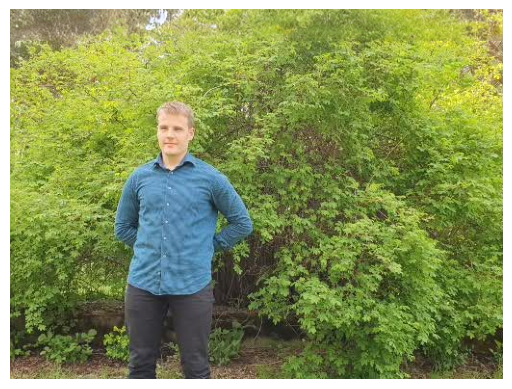

In [26]:
plt.imshow(Infilled_example_image)
plt.axis('off')
plt.show()

### 3.4.2 Example objects

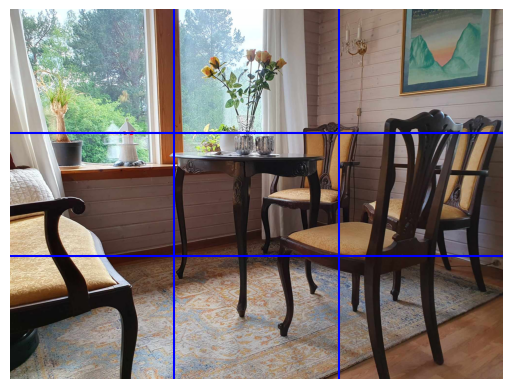

In [27]:
#Set the path to the image
Example_image_object_path ="report_images\Example_objects.png"

Example_image_object = Image.open(Example_image_object_path)
width, height = Example_image_object.size

plt.imshow(Example_image_object)
plt.axis('off')
Draw_thirds(height, width)
plt.show()

Let’s see the objects which the object detection found.

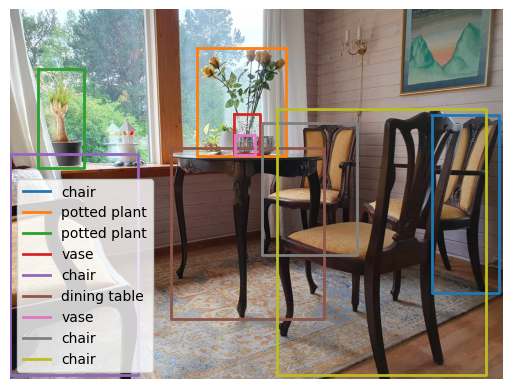

In [28]:
set_seed(seed)
Display_object_detection(Example_image_object)

In [29]:
print(get_possible_subjects(Example_image_object))

['dining table', 'vase', 'potted plant', 'chair']


We will try to focus on each of the objects in the image, but not vase. This is because it detected 2 overlapping vases which means it won’t work as wanted.

In [30]:
set_seed(seed)
image_potted_plant, mask_potted_plant = refram_to_thirds(Example_image_object, Subject = "potted plant", Return_mask = True)
image_chair, mask_chair = refram_to_thirds(Example_image_object, Subject = "chair", Return_mask = True)
image_dining_table, mask_dining_table = refram_to_thirds(Example_image_object, Subject = "dining table", Return_mask = True)

Number of subjects: 2
dx: 431, dy: 92
Horizontal line, top
Line vector: [0.0462400793650794, -0.36642857142857144]
zoom factor: 1.364522417153996, zoom origin: (504, 1008)
Number of subjects: 4
dx: -55, dy: 87
Horizontal line, bottom
Line vector: [0.16341931216931216, -0.7945039682539683]
zoom factor: 0.6293234772619434, zoom origin: (1008, 1008)
Number of subjects: 1


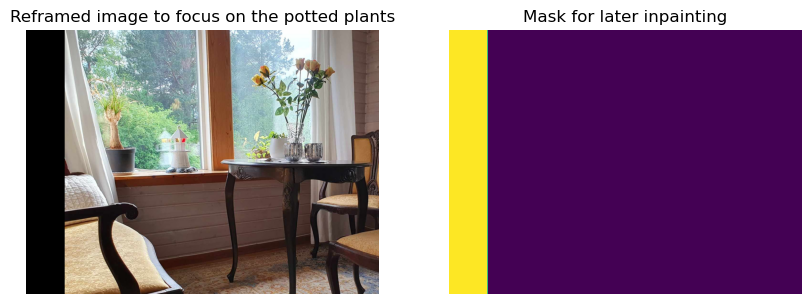

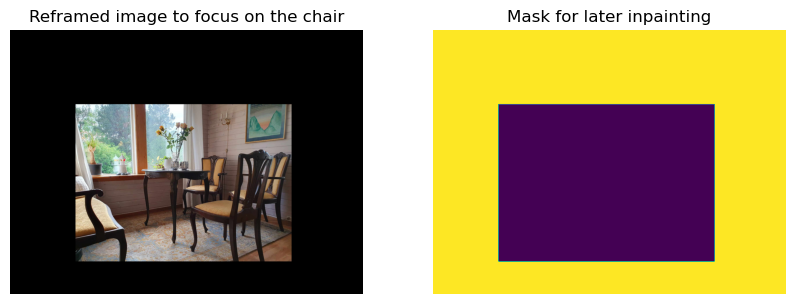

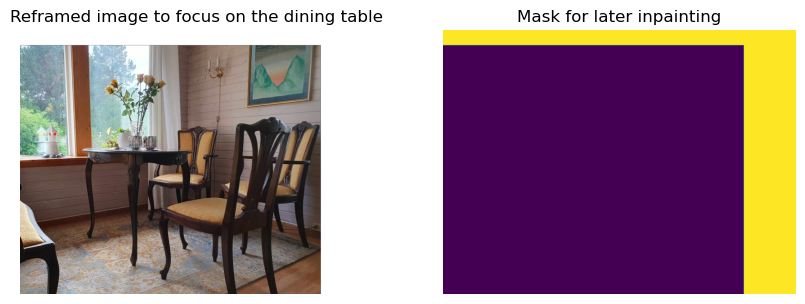

In [31]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))  # Create 2 subplots

# for the potted plant
axs[0].imshow(image_potted_plant)
axs[0].set_title("Reframed image to focus on the potted plants")
axs[0].axis('off')

axs[1].imshow(mask_potted_plant)
axs[1].set_title("Mask for later inpainting")
axs[1].axis('off')

plt.show()

# for the chair
fig, axs = plt.subplots(1, 2, figsize=(10, 5))  # Create 2 subplots

axs[0].imshow(image_chair)
axs[0].set_title("Reframed image to focus on the chair")
axs[0].axis('off')

axs[1].imshow(mask_chair)
axs[1].set_title("Mask for later inpainting")
axs[1].axis('off')

#for the dining table
fig, axs = plt.subplots(1, 2, figsize=(10, 5))  # Create 2 subplots

axs[0].imshow(image_dining_table)
axs[0].set_title("Reframed image to focus on the dining table")
axs[0].axis('off')

axs[1].imshow(mask_dining_table)
axs[1].set_title("Mask for later inpainting")
axs[1].axis('off')

plt.show()




Now we do infill for each of them

In [32]:
set_seed(seed)
image_potted_plant_infill = Infill(image_potted_plant, mask_potted_plant, prompt="")
image_chair_infill = Infill(image_chair, mask_chair, prompt="")
image_dining_table_infill = Infill(image_dining_table, mask_dining_table, prompt="")

unet\diffusion_pytorch_model.safetensors not found
100%|██████████| 50/50 [00:07<00:00,  6.49it/s]
unet\diffusion_pytorch_model.safetensors not found
100%|██████████| 50/50 [00:07<00:00,  6.55it/s]
unet\diffusion_pytorch_model.safetensors not found
100%|██████████| 50/50 [00:07<00:00,  6.52it/s]


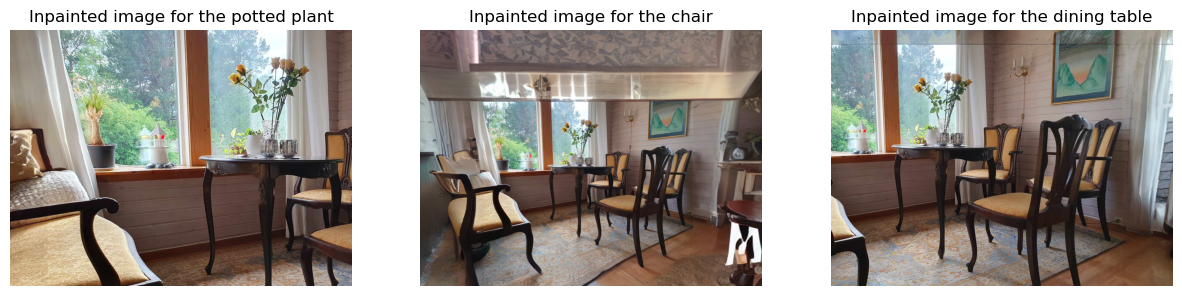

In [33]:
#make 3 subplots for the inpainted images
fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # 1 row, 3 columns

axs[0].imshow(image_potted_plant_infill)
axs[0].set_title("Inpainted image for the potted plant")
axs[0].axis('off')

axs[1].imshow(image_chair_infill)
axs[1].set_title("Inpainted image for the chair")
axs[1].axis('off')

axs[2].imshow(image_dining_table_infill)
axs[2].set_title("Inpainted image for the dining table")
axs[2].axis('off')

plt.show()

## 3.5 Discussing result of reframing pipeline

From the examples used here we have some good and some bad results, but overall I it worked better than expected and works as an proof of concept. When it comes to the object detection it performed very good except when it detects an object twice. This could possibly be mitigated by adjusting the confidence threshold used. The clothing detection also worked very well. Cropping the image using the boxes found by the object detection greatly helps the clothing detection. This is also necessary for cases with multiple people.

The biggest limitation of the pipeline is the infill, still when used sparingly it works very well as seen in example with “person”. In that case it would practically be impossible to see which part of the image was filled in using inpaint. This is likely due to only a sliver of the image needing to be filled in.

We can also see this in case of where we readjusted to focus on the potted plant the inpaint worked as intended. In that case there was only a strip on the left which needed filling in, still it was bigger than the case with the person.

In the case with the dining table, we needed to fill in on top and right. On the top it seems to pick up on the right patterns, but they are a bit of which makes it stand out. When first looking at the right side it might not seem wrong, but with a closer look we see that it is clearly not correct.

With the case where we focus on the chairs the model needed to do a lot of inpainting which not surprisingly leads to a bad result. Still, we can see it start to fill in something that seems right before it goes wrong. This clearly demonstrates the facts that the bigger the area which needing filling in the more chances the model must go wrong since it has less and less context.

Still different runs of the same image in the Inpaint model result in different results (given random seed). Some better and some worse. Therefore, it might be beneficial to run the Inpaint multiple times and manually pick out the best results. This comes of course at a cost of computation time especially since the Inpaint is the most computationally costly process in the pipeline.

There are some limitations when it comes to the choice of subject. This mainly occurs since the object detection must be able to pick up on it. So, for example if the subject was a mountain peak it would not work with this pipeline. 


# 4. Photographic Improvement using LLMs
Camera software has improved drastically in recent years, using algorithms and even AI to enhance and improve the image taken. Therefore, a lot of the remaining potential for improvement in an image comes down to the user of the camera. The ordinary person might not know about basic rules of photography, which means they could be guided by LLMs. If the user takes a bad image, both related to image content and photographic esthetic, a LLM could give feedback on what the user should change.


## 4.1 Background
Advances in artificial intelligence (AI) and machine learning have significantly impacted various domains, including image processing and enhancement. One of the cutting-edge developments in this field is the integration of natural language processing (NLP) and computer vision (CV), exemplified by models such as the Large Language and Vision Assistant (LLaVA). LLaVA represents a convergence of these two powerful AI capabilities, enabling a more intuitive and effective approach to image analysis and enhancement.

Traditionally, NLP and CV have been distinct fields with specialized models for text and image data, respectively. NLP focuses on the understanding and generation of human language, while CV is concerned with interpreting and processing visual information. The integration of these two domains allows for more sophisticated applications that can understand and interact with visual data in a contextually aware manner.

The LLaVA model leverages this integration by combining the language understanding capabilities of models like GPT-4 with the visual comprehension strengths of advanced image processing networks. This hybrid model can analyze images and generate contextually relevant responses, making it particularly useful for tasks that require an understanding of both visual and textual information.

Photographic enhancement is a critical application of AI in everyday life, with widespread use in social media, professional photography, and image-based content creation. Enhancing image quality involves a variety of tasks such as color correction, noise reduction, sharpness enhancement, and more. Traditionally, these tasks required manual intervention and expertise in image editing software. However, with the advent of models like LLaVA, it is possible to automate these enhancements by understanding the content and context of an image and applying the necessary improvements.


## 4.2 Implementation

### 4.2.1 Image to Text Feedback

In [41]:
#pip install diffusers transformers accelerate scipy safetensors accelerate
#pip install -i https://pypi.org/simple/ bitsandbytes
import requests
from PIL import Image
import torch
from transformers import AutoProcessor, LlavaForConditionalGeneration

image_path = "report_images\Example_person.png"

image = Image.open(image_path)  # Image 

model_id = "llava-hf/llava-1.5-7b-hf"  # Model
prompt_in = "USER: Describe how this image can be improved <image>\nASSISTANT:"  # Prompt

model = LlavaForConditionalGeneration.from_pretrained(
    model_id,
    torch_dtype=torch.float16,
    low_cpu_mem_usage=True,
    # load_in_4bit=True
).to(device)

# Model parameters make it possible to run locally

processor = AutoProcessor.from_pretrained(model_id)  # Processes image

inputs = processor(prompt_in, image, return_tensors='pt').to(0, torch.float16)

output = model.generate(**inputs, max_new_tokens=200, do_sample=False)
prompt_out = processor.decode(output[0][:], skip_special_tokens=True)
print(prompt_out)

c:\Users\mgphy\Anaconda3\envs\genai-test\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Loading checkpoint shards: 100%|██████████| 3/3 [00:00<00:00,  4.20it/s]
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


USER: Describe how this image can be improved  
ASSISTANT: To improve the image, the man could be positioned in a more visually appealing way. Instead of standing in the middle of the grass, he could be standing on a patch of grass or a small mound, which would create a more balanced composition. Additionally, the man could be posing in a more dynamic manner, such as leaning against a tree or a wall, to add more interest to the image. Finally, the background could be enhanced by adding more elements like a bench, a chair, or a small table to create a more engaging and visually interesting scene.


USER: Describe how this image can be improved  
ASSISTANT: To improve the image, the man could be positioned in a more visually appealing way. Instead of standing in the middle of the grass, he could be standing on a patch of grass or a small mound, which would create a more balanced composition. Additionally, the man could be posing in a more dynamic manner, such as leaning against a tree or a wall, to add more interest to the image. Finally, the background could be enhanced by adding more elements like a bench, a chair, or a small table to create a more engaging and visually interesting scene.


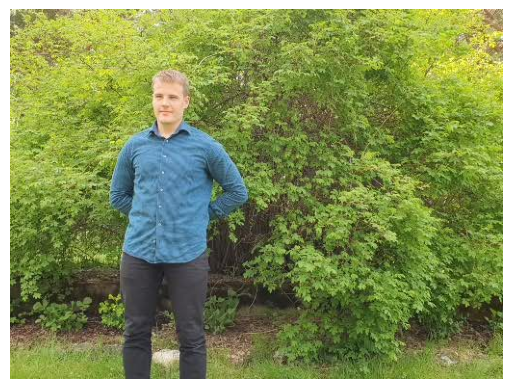

In [42]:
import matplotlib.pyplot as plt
plt.imshow(image)
plt.axis('off')
print(prompt_out)

ASSISTANT: To improve the image, the man could be positioned in a more visually appealing way. Instead of standing in the middle of the grass, he could be standing on a patch of grass or a small mound, which would create a more balanced composition. Additionally, the man could be posing in a more dynamic manner, such as leaning against a tree or a wall, to add more interest to the image. Finally, the background could be enhanced by adding more elements like a bench, a chair, or a small table to create a more engaging and visually interesting scene.

### 4.2.2 Image to Image Improver
The original idea in this section of the report was to find a model which could automatically improve a given picture. This task was attempted such:

__Warning__: This cell requires a lot of CUDA memory

In [ ]:
from PIL import Image
import torch
from diffusers import StableDiffusionInstructPix2PixPipeline, EulerAncestralDiscreteScheduler

model_id = "timbrooks/instruct-pix2pix"
pipe = StableDiffusionInstructPix2PixPipeline.from_pretrained(model_id, torch_dtype=torch.float16, safety_checker=None)
pipe.to("cuda")
pipe.scheduler = EulerAncestralDiscreteScheduler.from_config(pipe.scheduler.config)

image_path = "report_images\Example_person.png"
image = Image.open(image_path)  # Image 
prompt_out = "To improve the image, the man could be positioned in a more visually appealing way. Instead of standing in the middle of the grass, he could be standing on a patch of grass or a small mound, which would create a more balanced composition. Additionally, the man could be posing in a more dynamic manner, such as leaning against a tree or a wall, to add more interest to the image. Finally, the background could be enhanced by adding more elements like a bench, a chair, or a small table to create a more engaging and visually interesting scene."
images = pipe(prompt_out, image=image, num_inference_steps=10, image_guidance_scale=1).images
images[0]

## 4.3 Discussion
Using the LLaVA model for photographic improvements reveals significant potential for integrating natural language processing and computer vision to enhance image quality.

### 4.3.1 Strengths of the LLaVA Model

By leveraging its language model capabilities, LLaVA can generate detailed and specific recommendations for photographic improvements. For instance, it can suggest increasing brightness, reducing noise, or enhancing sharpness based on its analysis of the image. This reduces the need for manual inspection and enhances the efficiency of the image editing process.

The model's versatility is evident in its applicability to various enhancement tasks, including color correction, noise reduction, and sharpness enhancement. This makes LLaVA a valuable tool for a wide range of users, from amateur photographers to professionals looking for quick and effective image improvements. This might however require a more precise prompt than we were able to achieve in this project.

### 4.3.2 Limits of the LLaVA Model
Despite its strengths, the LLaVA model has limitations. It may not always generate perfect suggestions, particularly for complex images requiring subtle adjustments. The quality of suggestions is influenced by the diversity and quality of the data used to train the model, and there may be cases where manual intervention is still necessary to achieve the desired results. The model used in this project was pretrained, and therefore unable to give reliably specific feedback.

### 4.3.2 Analysis of Results:

In [ ]:
print(prompt_out)

USER: Describe how this image can be improved  
ASSISTANT: To improve the image, the man could be positioned in a more visually appealing way. Instead of standing in the middle of the grass, he could be standing near the edge of the grass, creating a more dynamic and interesting scene. Additionally, the man could be wearing a more colorful or interesting shirt to draw attention to him and make the image more engaging. Finally, the background could be enhanced by adding more elements, such as trees, flowers, or other natural elements, to create a more vibrant and visually appealing scene.


The feedback given can generally be used enhance the image. However, in the tested images, it struggles to provide specific improvements related to image composition, making it less suitable for higher-level photography.

Integrating concepts from art and photography, such as the rule of thirds, leading lines, and balance, into the model's training process could improve its ability to offer compositional feedback. This could involve using reinforcement learning where the model is rewarded for suggestions that align with these principles.

Implementing a feedback loop where users can provide input on the model's suggestions can help refine its understanding of composition. Users could rate the relevance and quality of the feedback, enabling continuous improvement through iterative learning.

### 4.3.3 Using the Feedback as a Prompt for an Image to Image System
Our original idea for this part of the project was to create an I2I system where the input image gets automatically improved. This proved hard in challenge as ensuring that the textual prompts generated by the LLaVA model were sufficiently detailed and actionable for the system was difficult, as this required fine-tuning the language model to produce precise and relevant feedback. This became too big of a challenge to overcome as the high computational requirements for both models necessitate access to powerful GPUs and substantial memory, which became too grave a problem even for Google Colab. Moreover, the complexity of integrating two sophisticated AI systems can introduce technical challenges related to system compatibility, synchronization, and error handling.

# 5. Conclusion

(Conclusion written with the help of ChatGPT)

Our exploration into leveraging generative AI tools for improving the aesthetics of images has yielded insightful and varied outcomes across our three key tasks. Firstly, while we hypothesized that image-generating models might possess an inherent aesthetic sense that could be exploited to measure the visual appeal of images, our findings were inconclusive. The embeddings generated by image-to-image models did not sufficiently differentiate between aesthetically pleasing and unpleasing images, indicating that these models may not inherently recognize or prioritize aesthetic value.

However, our second task, which involved designing a pipeline to modify images according to the rule of thirds, proved more successful. It successfully demonstrates a proof of concept for a reframing pipeline that combines object detection, clothing detection, and inpainting techniques. The object detection component performed reliably, with minor issues such as detecting the same object twice, which could be resolved by adjusting the confidence threshold. The clothing detection was also highly effective, particularly when combined with image cropping based on object detection, which is crucial for handling images with multiple people.
The inpainting process, while generally effective, revealed limitations when larger areas required filling. Smaller areas yielded nearly imperceptible inpainting, but larger areas resulted in noticeable inaccuracies. Running the inpainting multiple times and selecting the best result could mitigate this issue, though it increases computational demands. Additionally, the effectiveness of the pipeline is dependent on the capability of the object detection to accurately identify the subject, limiting its use with less common or complex subjects.

Lastly, the integration of natural language processing and computer vision through the LLaVA model for our third task showed significant potential. The model was capable of generating detailed and specific recommendations for photographic improvements, highlighting the feasibility of using AI-driven chatbots to provide real-time, personalized feedback to photographers. While the suggestions were not always perfect, particularly for complex images requiring subtle adjustments, the results underscore the value and potential of combining AI with artistic guidance.

In conclusion, our project has highlighted both the challenges and opportunities in using generative AI for enhancing image aesthetics. While not all aspects yielded conclusive results, the advancements in applying aesthetic principles and integrating NLP with computer vision indicate a promising future for AI-driven tools in the field of photography.

# References

1. Zhang, Jiajing, Yongwei Miao, and Jinhui Yu. "A comprehensive survey on computational aesthetic evaluation of visual art images: Metrics and challenges." IEEE Access 9 (2021): 77164-77187.
2. Kong, Shu, et al. "Photo aesthetics ranking network with attributes and content adaptation." Computer Vision–ECCV 2016: 14th European Conference, Amsterdam, The Netherlands, October 11–14, 2016, Proceedings, Part I 14. Springer International Publishing, 2016.
3. Higgins, Irina, et al. "beta-vae: Learning basic visual concepts with a constrained variational framework." ICLR (Poster) 3 (2017).
4. Deng, Yubin, Chen Change Loy, and Xiaoou Tang. "Image aesthetic assessment: An experimental survey." IEEE Signal Processing Magazine 34.4 (2017): 80-106.
5. Yang, Shuai, et al. "A self-supervised image aesthetic assessment combining masked image modeling and contrastive learning." Journal of Visual Communication and Image Representation (2024): 104184.